# Figure 3 script

In [1]:
import glaft
import pandas as pd
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm as cramericm

In [2]:
# font and linewidth settings
font = {'size'   : 14}
mpl.rc('font', **font)
axes_settings = {'linewidth'   : 2}
mpl.rc('axes', **axes_settings)

# read and select data
df = pd.read_csv('../manifest.csv', dtype=str)
in_shp = '/home/jovyan/Projects/PX_comparison/shapefiles/glacier_V1_Kaskawulsh_s_inwardBuffer600m.shp'
selected_cases = df.loc[[64, 79, 117]]
selected_cases

,Date,Duration (days),Template size (px),Template size (m),Pixel spacing (px),Pixel spacing (m),Prefilter,Subpixel,Software,Vx,Vy
64,LS8-20180802-20180818,16,64,960,1,15,NAOF,16-node oversampling,CARST,/home/jovyan/Projects/PX_comparison/PX/CARST/2...,/home/jovyan/Projects/PX_comparison/PX/CARST/2...
79,LS8-20180802-20180818,16,varying: multi-pass,varying: multi-pass,4.009,60.14,NAOF,interest point groups,GIV,/home/jovyan/Projects/PX_comparison/PX/GIV/u_l...,/home/jovyan/Projects/PX_comparison/PX/GIV/v_l...
117,LS8-20180802-20180818,16,31,465,1,15,LoG,affine,Vmap,/home/jovyan/Projects/PX_comparison/PX/Vmap/su...,/home/jovyan/Projects/PX_comparison/PX/Vmap/su...


This cell performs the static terrain analysis and calculates the corresponding metrics.

In [3]:
exps = {}

for idx, row in selected_cases.iterrows():
    exp = glaft.Velocity(vxfile=row.Vx, vyfile=row.Vy, on_ice_area=in_shp, kde_gridsize=60, thres_sigma=2.0)
    exp.longitudinal_shear_analysis()
    exps[idx] = exp

Running clip_on_ice_area
Running get_grid_spacing
Running calculate_flow_theta
Running calculate_strain_rate
Running prep_strain_rate_kde
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_on_ice_area
Running get_grid_spacing
Running calculate_flow_theta
Running calculate_strain_rate
Running prep_strain_rate_kde
Running calculate_xystd
Running calculate_bandwidth
Running calculate_kde
Running construct_crude_mesh
Running eval_crude_mesh
Running construct_fine_mesh
Running eval_fine_mesh
Running thresholding_fine_mesh
Running thresholding_metric
Running cal_outlier_percent
Running clip_on_ice_area
Running get_grid_spacing
Running calculate_flow_theta
Running calculate_strain_rate
Running prep_strain_rate_kde
Running calculate_xystd
Running calculate_bandwidth
Runn

The following functions plot the braces on the axes with annotations, which is necessary for Figure 2. They are modified from guzey's answer to [this StackOverflow thread](https://stackoverflow.com/questions/18386210/annotating-ranges-of-data-in-matplotlib/68180887#68180887).

In [4]:
def draw_brace_x(ax, xspan: tuple=(None, None), yy: float=0.0, text: str=''):
    """
    ax: axes to be drawn.
    xspan: x coordinates of the two brace ending points.
    yy: y coordinate of the two brace ending points. (The brace will be placed horizontally)
    text: annotation text.
    """

    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan / xax_span * 100) * 2 + 1 # sampling resolution of the sigmoid brace
    beta = 200. / xax_span                           # the higher this is, the sharper the sigmoid

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution / 2) + 1]
    y_half_brace = (1 / (1. + np.exp(-beta * (x_half - x_half[0] )))
                  + 1 / (1. + np.exp(-beta * (x_half - x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy - (.05 * y - .01) * yspan                 # adjust vertical stretch and position

    ax.plot(x, y, color='black', lw=1)
    ax.text((xmax + xmin) / 2., yy - .07 * yspan, text, ha='left', va='top')
    
def draw_brace_y(ax, yspan: tuple=(None, None), xx: float=0.0, text: str=''):
    """
    ax: axes to be drawn.
    yspan: y coordinates of the two brace ending points.
    xx: x coordinate of the two brace ending points. (The brace will be placed vertically)
    text: annotation text.
    """

    ymin, ymax = yspan
    yspan = ymax - ymin
    ax_ymin, ax_ymax = ax.get_ylim()
    yax_span = ax_ymax - ax_ymin

    xmin, xmax = ax.get_xlim()
    xspan = xmax - xmin
    resolution = int(yspan / yax_span * 100) * 2 + 1 # sampling resolution of the sigmoid brace
    beta = 200. / yax_span                           # the higher this is, the sharper the sigmoid

    y = np.linspace(ymin, ymax, resolution)
    y_half = y[:int(resolution / 2) + 1]
    x_half_brace = (1 / (1. + np.exp(-beta * (y_half - y_half[0] )))
                  + 1 / (1. + np.exp(-beta * (y_half - y_half[-1]))))
    x = np.concatenate((x_half_brace, x_half_brace[-2::-1]))
    x = xx - (.05 * x - .01) * xspan                 # adjust vertical stretch and position

    ax.plot(x, y, color='black', lw=1)
    ax.text(xx - .05 * xspan, (ymax + ymin) / 2., text, rotation=90, ha='right', va='bottom')

Now starting to make the figure:

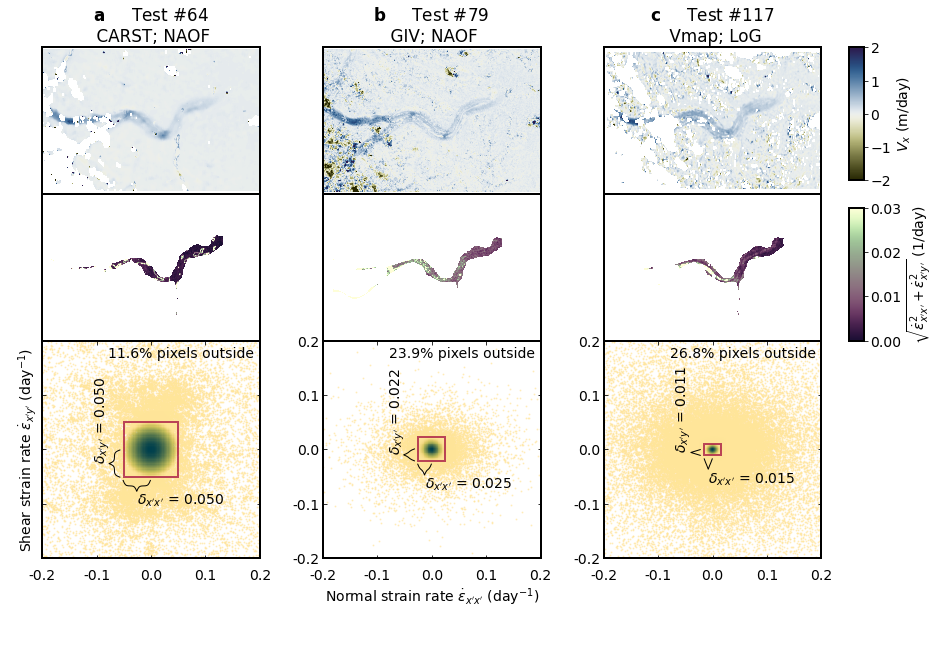

In [5]:
# vmax = exps[117].metric_alongflow_normal
vmax = 0.03

fig = plt.figure(figsize=(13, 9.5))
subfigs = fig.subfigures(1, 4, wspace=0, hspace=0, width_ratios=(0.3, 0.3, 0.3, 0.1))    # last column is for colorbar
all_axs = np.empty(4, dtype='object')

# create three subplots in each subfigure
for i, subfig in enumerate(subfigs[:3]):
    all_axs[i] = subfig.subplots(3, 1, gridspec_kw = {'hspace':0, 'height_ratios':(0.28377, 0.28377, 0.43246)})
# a = 0.3962, b = 0.6038 (from Figure 2)
# x = a/(2a + b) = 0.28377
# y = b/(2a + b) = 0.43246

title_labels = np.array(['$\mathbf{a}$ \t Test #64 \n CARST; NAOF', 
                         '$\mathbf{b}$ \t Test #79 \n GIV; NAOF', 
                         '$\mathbf{c}$ \t Test #117 \n Vmap; LoG'])

for idx, i in [[64, 0], [79, 1], [117, 2]]:
    
    exp = exps[idx]
    
    # top panel
    ax_sel = all_axs[i][0]
    cm_settings = glaft.show_velocomp(exp.vxfile, ax=ax_sel)
    ax_sel.set_aspect('equal', adjustable='datalim')
    ax_sel.set_title(title_labels[i])
    
    # middle panel
    ax_sel = all_axs[i][1]
    mappable_strain = exp.plot_strain_map(ax=ax_sel, vmax=vmax, base_colormap=cramericm.tokyo)
    ax_sel.set_aspect('equal', adjustable='datalim')
    
    # bottom panel
    ax_sel = all_axs[i][2]
    exp.plot_zoomed_extent(metric=2, ax=ax_sel)
    ax_sel.set_aspect('equal', adjustable='box')
    ax_sel.set_xlim(-0.2, 0.2)
    ax_sel.set_ylim(-0.2, 0.2)
    ax_sel.set_title(None)
    
    # bottom panel ticks
    ax_sel.tick_params(direction="in", bottom=True, top=True, left=True, right=True)
    ax_sel.tick_params(axis='x', pad=10)
    ax_sel.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax_sel.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax_sel.set_yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
    ax_sel.set_xticks([-0.2, -0.1, 0.0, 0.1, 0.2])
    
    # show percentage of pixels outside
    ax_sel.text(0.19, 0.19, '{:.1f}% pixels outside'.format(exp.outlier_percent * 100), ha='right', va='top')
    
    # annotations of du and dv
    draw_brace_x(ax_sel, 
                 xspan=(exp.kdepeak_x - exp.metric_alongflow_normal, exp.kdepeak_x), 
                 yy=exp.kdepeak_y - exp.metric_alongflow_shear, 
                 text="$\delta_{x'x'}$" + " = {:.3f}".format(exp.metric_alongflow_normal))
    draw_brace_y(ax_sel, 
                 yspan=(exp.kdepeak_y - exp.metric_alongflow_shear, exp.kdepeak_y), 
                 xx=exp.kdepeak_x - exp.metric_alongflow_normal, 
                 text="$\delta_{x'y'}$" + " = {:.3f}".format(exp.metric_alongflow_shear))

    
    
# fine-tune positions of the top panels
# x0 = left, x1 = right, y0 = bottom, y1 = top
bbox_top    = all_axs[0][0].get_position()
bbox_middle = all_axs[0][1].get_position()
bbox_bottom = all_axs[0][2].get_position()

bbox_bottom_vertical_shift = bbox_middle.y0 - bbox_bottom.y1
bbox_bottom.y0 = bbox_bottom.y0 + bbox_bottom_vertical_shift
bbox_bottom.y1 = bbox_bottom.y1 + bbox_bottom_vertical_shift

for i, subfig in enumerate(all_axs[:3]):
    all_axs[i][2].set_position(bbox_bottom)

# add colorbars
mappable_velo = glaft.prep_colorbar_mappable(**cm_settings)
cax = subfigs[3].add_axes([0.0, bbox_top.y0 + 0.02, 0.15, bbox_top.y1 - bbox_top.y0 - 0.02])
subfigs[3].colorbar(mappable_velo, cax=cax, orientation='vertical', label='$V_x$ ({})'.format(exp.velocity_unit), ticks=[-2, -1, 0, 1, 2])

cax2 = subfigs[3].add_axes([0.0, bbox_middle.y0, 0.15, bbox_middle.y1 - bbox_middle.y0 - 0.02])
strain_cmap_label = "$\sqrt{\dot{\epsilon}_{x'x'}^2 + \dot{\epsilon}_{x'y'}^2}$ (1/day)"
subfigs[3].colorbar(mappable_strain, cax=cax2, orientation='vertical', label=strain_cmap_label, ticks=[0, 0.01, 0.02, 0.03])

# add axis labels
all_axs[0][2].set_yticklabels(['', '', '', '', ''])                                      # to prevent label bleeding
all_axs[0][2].set_ylabel("Shear strain rate $\dot{\epsilon}_{x'y'}$ (day$^{-1}$)", labelpad=-0.0)    # ditto

all_axs[1][2].set_xlabel("Normal strain rate $\dot{\epsilon}_{x'x'}$ (day$^{-1}$)")

# save figure
fig.patch.set_facecolor('xkcd:white')
fig.savefig('Fig3.png', dpi=200)